In [1]:
from bloqade import qasm2
from bloqade.pyqrack import PyQrack
from bloqade.qasm2.emit import QASM2 # the QASM2 target
from bloqade.qasm2.parse import pprint # the QASM2 pretty printer

from qiskit import QuantumCircuit
from src.helper import get_qasm_string

/Users/randybleximo/Desktop/Batista Lab/QC/YQuantum/charlie_delta/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/randybleximo/Desktop/Batista Lab/QC/YQuantum/charlie_delta/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/randybleximo/Desktop/Batista Lab/QC/YQuantum/charlie_delta/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# 1. Tutorial Circuit QASM Strings Are Not Valid (Not QASM2 Compatible)

## 1.1 Example from [GHZ_tutorial_v3.ipynb](https://github.com/IgnacioBlancasRodriguez/yquantum/blob/main/2025/GHZ_tutorial_v3.ipynb)
(but all circuits from [Bloqade Digital Tutorials](https://bloqade.quera.com/latest/digital/) have the same problem)

In [2]:
def ghz_linear(n: int):
    n_qubits = int(2**n)

    @qasm2.extended
    def ghz_linear_program():

        qreg = qasm2.qreg(n_qubits)
        # Apply a Hadamard on the first qubit
        qasm2.h(qreg[0])
        # Create a cascading sequence of CX gates
        # necessary for quantum computers that
        # only have nearest-neighbor connectivity between qubits
        for i in range(1, n_qubits):
            qasm2.cx(qreg[i - 1], qreg[i])

    return ghz_linear_program

In [3]:
target = QASM2()
ast = target.emit(ghz_linear(2))
pprint(ast)

OPENQASM 2.0;
include "qelib1.inc";
qreg qreg[4];
h qreg[0];
CX qreg[0], qreg[1];
CX qreg[1], qreg[2];
CX qreg[2], qreg[3];


In [4]:
qasm_string = get_qasm_string(ast)
circuit = QuantumCircuit.from_qasm_str(qasm_string)
circuit.draw('mpl')

"""QASM2ParseError: '<input>:3,5: needed a valid identifier, but instead saw qreg'"""

QASM2ParseError: '<input>:3,5: needed a valid identifier, but instead saw qreg'

## 1.2 Correct Way to Define the Circuit (Do Not Use the Reserved QASM Commands)

In [7]:
def ghz_linear_correct(n: int):
    n_qubits = int(2**n)

    @qasm2.extended
    def ghz_linear_program():

        qr = qasm2.qreg(n_qubits)
        # Apply a Hadamard on the first qubit
        qasm2.h(qr[0])
        # Create a cascading sequence of CX gates
        # necessary for quantum computers that
        # only have nearest-neighbor connectivity between qubits
        for i in range(1, n_qubits):
            qasm2.cx(qr[i - 1], qr[i])

    return ghz_linear_program

In [8]:
target = QASM2()
ast = target.emit(ghz_linear_correct(2))
pprint(ast)

OPENQASM 2.0;
include "qelib1.inc";
qreg qr[4];
h qr[0];
CX qr[0], qr[1];
CX qr[1], qr[2];
CX qr[2], qr[3];


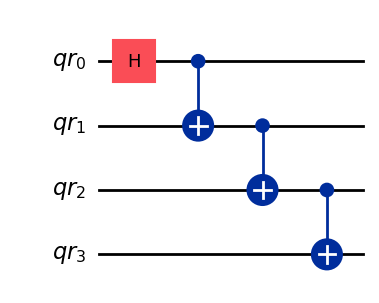

In [9]:
qasm_string = get_qasm_string(ast)
circuit = QuantumCircuit.from_qasm_str(qasm_string)
circuit.draw('mpl')

# 1.3 How to Prevent this from Even Happening (reserve variable names)

In [10]:
"""
To improve robustness and ensure compliance with QASM2 syntax,
extra dialect might be added which would allow to automatically detection naming conflicts with reserved QASM2
keywords—such as qreg, creg, gate, or measure. When detected the node transformer can be used to rename conflicting
identifiers to ensure that generated QASM2 is valid. This approach would increase reliability of the QASM2 outputs.
"""

import ast


def qasm_safe_renaming(tree, config=None):
    """
    Kirin-style dialect that renames Python variable names
    conflicting with QASM2 reserved words.
    """
    if config is None:
        config = {}

    reserved = {
        "qreg",
        "creg",
        "gate",
        "measure",
        "reset",
        "barrier",
        "opaque",
        "if",
        "else",
        "pi",
        "sin",
        "cos",
        "tan",
        "exp",
        "ln",
        "sqrt",
        "include",
        "openqasm",
        "qasm",
    }

    suffix = config.get("suffix", "_var")

    class RenameVisitor(ast.NodeTransformer):
        def __init__(self):
            self.renamed = {}

        def rename_if_reserved(self, name):
            if name in reserved:
                new_name = f"{name}{suffix}"
                self.renamed[name] = new_name
                return new_name
            return name

        def visit_Name(self, node):
            if isinstance(node.ctx, ast.Store | ast.Load):
                node.id = self.renamed.get(node.id, self.rename_if_reserved(node.id))
            return node

        def visit_arg(self, node):
            node.arg = self.renamed.get(node.arg, self.rename_if_reserved(node.arg))
            return node

        def visit_FunctionDef(self, node):
            node.name = self.renamed.get(node.name, self.rename_if_reserved(node.name))
            self.generic_visit(node)
            return node

        def visit_ClassDef(self, node):
            node.name = self.renamed.get(node.name, self.rename_if_reserved(node.name))
            self.generic_visit(node)
            return node

    return RenameVisitor().visit(tree)


example_code = """
def gate(qreg, pi):
    creg = qreg + 1
    return creg + pi
"""

tree = ast.parse(example_code)

transformed_tree = qasm_safe_renaming(tree, config={"suffix": "_var"})

print("= Transformed Code =")
print(ast.unparse(transformed_tree))

= Transformed Code =
def gate_var(qreg_var, pi_var):
    creg_var = qreg_var + 1
    return creg_var + pi_var


# 2. Dialects Not Supporting Certain Operators 

## 2.1 Dialects Not Supporting Boolean Operators 

In [11]:
@qasm2.extended
def circ_bool():
    qr = qasm2.qreg(4)
    cr = qasm2.creg(4)
    # Apply NOT gates to first 3 qubits
    qasm2.x(qr[0])
    qasm2.x(qr[1]) 
    qasm2.x(qr[2])
    
    # Apply controlled-Z gates between pairs of qubits
    qasm2.cx(qr[0], qr[1])
    qasm2.cx(qr[1], qr[2])
    qasm2.cz(qr[2], qr[3])
    qasm2.cz(qr[0], qr[3])

    qasm2.measure(qr[0], cr[0])
    qasm2.measure(qr[1], cr[1])
    qasm2.measure(qr[2], cr[2])
    qasm2.measure(qr[3], cr[3])
    
    if cr[0] == 0 and cr[1] == 1:
        qasm2.x(qr[3])

    return qr

In [13]:
target = QASM2()
ast = target.emit(circ_bool)
pprint(ast)

ValueError: dialect py.boolop is not supported by DialectGroup([qasm2.uop, qasm2.expr, qasm2.core, func, lowering.call, scf, qasm2.indexing, lowering.func])

## 2.2 Dialects Not Supporting Nested Operators 

In [28]:
@qasm2.extended
def circ_nested():
    qr = qasm2.qreg(4)
    cr = qasm2.creg(4)
    # Apply NOT gates to first 3 qubits
    qasm2.x(qr[0])
    qasm2.x(qr[1]) 
    qasm2.x(qr[2])
    
    # Apply controlled-Z gates between pairs of qubits
    qasm2.cx(qr[0], qr[1])
    qasm2.cx(qr[1], qr[2])
    qasm2.cz(qr[2], qr[3])
    qasm2.cz(qr[0], qr[3])

    qasm2.measure(qr[0], cr[0])
    qasm2.measure(qr[1], cr[1])
    qasm2.measure(qr[2], cr[2])
    qasm2.measure(qr[3], cr[3])
    
    if cr[0] == 0:
        if cr[1] == 1:
            qasm2.x(qr[3])

    return qr

In [29]:
target = QASM2()
ast = target.emit(circ_nested)
pprint(ast)

OPENQASM 2.0;
include "qelib1.inc";
qreg qr[4];
creg cr[4];
x qr[0];
x qr[1];
x qr[2];
CX qr[0], qr[1];
CX qr[1], qr[2];
cz qr[2], qr[3];
cz qr[0], qr[3];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];
measure qr[2] -> cr[2];
measure qr[3] -> cr[3];
if (cr[0] == 0) if (cr[1] == 1) x qr[3];


### The QASM string again is not valid at the "nested if" part

In [30]:
qasm_string = get_qasm_string(ast)
circuit = QuantumCircuit.from_qasm_str(qasm_string)
circuit.draw('mpl')

QASM2ParseError: "<input>:16,6: needed '==', but instead saw ["

# 3. Raising Code Quality through Adoption of the Engineering Best Practices

## 3.1 Example from a [Bloqade Test](https://github.com/QuEraComputing/bloqade/blob/823e8e84d109714dabe77a2f0f003e20d1faa846/test/qasm2/emit/test_qasm2_emit.py)

(i) avoid nested functions via the use of fixtures

(ii) adopt pytest for the assertions

(iii) avoid print statements

(iv) adopt arrange act assert practice

###  Also, the QASM string here again is not valid because the reserved command qreg is abused.

In [14]:
def test_global_allow_global_allow_para():

    @qasm2.extended
    def glob_u():
        qreg = qasm2.qreg(3)
        qreg1 = qasm2.qreg(3)
        qasm2.glob.u(theta=0.1, phi=0.2, lam=0.3, registers=[qreg, qreg1])

    target = qasm2.emit.QASM2(
        allow_global=True,
        allow_parallel=True,
        custom_gate=True,
    )
    qasm2_str = target.emit_str(glob_u)
    print(qasm2_str)
    assert (
        qasm2_str
        == """KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.glob,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg qreg[3];
qreg qreg1[3];
glob.U(0.1, 0.2, 0.3) {qreg, qreg1}
"""
    )

## 3.2 A Better Unit Test

In [37]:
import pytest
from bloqade.qasm2 import extended, qreg, glob, emit

@pytest.fixture
def custom_circuit():
    @extended
    def circuit():
        qreg_var = qreg(3)
        qreg_var1 = qreg(3)
        glob.u(theta=0.1, phi=0.2, lam=0.3, registers=[qreg_var, qreg_var1])
    return circuit

def test_global_allow_global_allow_para(custom_circuit):
    # Arrange
    target = emit.QASM2(
        allow_global=True,
        allow_parallel=True,
        custom_gate=True,
    )

    expected_qasm = """KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.glob,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg qreg_var[3];
qreg qreg_var1[3];
glob.U(0.1, 0.2, 0.3) {qreg_var, qreg_var1}
"""

    # Act
    qasm2_str = target.emit_str(custom_circuit)

    # Assert
    assert qasm2_str == expected_qasm


# 3.3 Example from a Bloqade Feature (Noise Model) [first part](https://github.com/QuEraComputing/bloqade/blob/823e8e84d109714dabe77a2f0f003e20d1faa846/src/bloqade/qasm2/passes/noise.py) and [second part](https://github.com/QuEraComputing/bloqade/blob/823e8e84d109714dabe77a2f0f003e20d1faa846/src/bloqade/noise/native/model.py)

### The current system for injecting noise into quantum circuits is somewhat rigid. While it applies a specific noise model and includes post-processing optimizations, it doesn't give users much flexibility to customize how noise behaves. In particular, key parameters that control the strength or character of gate-level noise aren’t exposed in a way that allows tuning or experimentation. As a result, users are locked into the default settings of the noise model, which may not reflect their specific use cases or experimental setups.